In [1]:
import sys, os

In [2]:
sys.path.insert(0, '/home/storage/hans/jax_reco_new/')

In [3]:
from lib.cgamma import c_gamma_prob
from lib.plotting import adjust_plot_1d

In [4]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt


In [5]:
from scipy.stats import norm
from jax.scipy.special import gamma, gammaincc
from scipy.integrate import quad
from scipy.stats import gamma as gamma_pdf
from scipy.stats import norm

In [7]:
def biweight_gamma(x, a, b, s):  
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

    gincc_a_m = gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = gammaincc(1+a, b*(x-s))*gamma(1+a)
    gincc_2pa_m = gammaincc(2+a, b*(x-s))*gamma(2+a)
    gincc_3pa_m = gammaincc(3+a, b*(x-s))*gamma(3+a)
    gincc_4pa_m = gammaincc(4+a, b*(x-s))*gamma(4+a)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * b**4 * (s**4 - 2*s**2*x**2 + x**4)
                + (g_1pa - gincc_1pa) * b**3 * (4*s**2*x - 4*x**3)
                + (g_2pa - gincc_2pa) * (b**2*(6*x**2 - 2*s**2))
                - g_2pa * (8*b*x + 4*a*b*x)
                + g_4pa - gincc_4pa
                + gincc_3pa * 4*b*x
    )
    
    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * (b**4*s**4 - 2*b**4*s**2*x**2 + b**4*x**4)
                + (gincc_1pa_m - gincc_1pa) * (4*b**3*s**2*x - 4*b**3*x**3)
                + (gincc_2pa- gincc_2pa_m) * (2*b**2*s**2 - 6*b**2*x**2)
                + (gincc_3pa - gincc_3pa_m) * (4*b*x)
                + gincc_4pa_m - gincc_4pa
                
    )

    # combined branches
    tsum = jnp.where(x < s, tsum0, tsum1)
    # set to 0 outside of support
    tsum = jnp.where(x < -s, 0.0, tsum)
    
    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum

In [13]:
def biweight(x, u, s):
    y =  15./(16.*s) * (1.0-((x-u)/s)**2)**2
    y = np.where(np.abs(x-u) <= s, y, 0.0)
    return y

def triweight(x, u, s):
    y =  35./(32.*s) * (1.0-((x-u)/s)**2)**3
    y = np.where(np.abs(x-u) <= s, y, 0.0)
    return y
    
def gamma_pdf_fn(x, a, b):
    y = gamma_pdf.pdf(x, a, scale=1/b)
    y = np.where(x <= 0, 0.0, y)
    return y

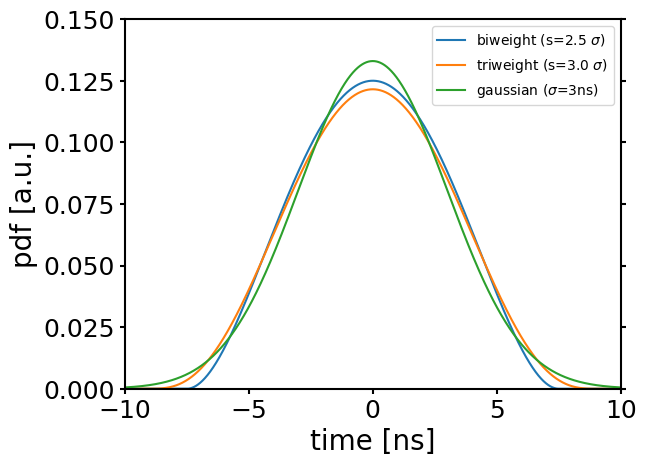

In [15]:
sigma = 3.0
xvals = np.linspace(-10, 30, 10000)

fig, ax = plt.subplots()
ax.plot(xvals, biweight(xvals, 0.0, 2.5 * sigma), label='biweight (s=2.5 $\sigma$)')
ax.plot(xvals, triweight(xvals, 0.0, 3.0 * sigma), label='triweight (s=3.0 $\sigma$)')
ax.plot(xvals, norm.pdf(xvals, 0.0, scale=sigma), label='gaussian ($\sigma$=3ns)')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 10], 
                 'ylim':[0.0, 0.15]}

adjust_plot_1d(fig, ax, plot_args=plot_args)

plt.show()

In [10]:
a = 3.75
b = 2.0
sigma = 3.0

xvals = np.linspace(-10, 30, 10000)
yvals_biweight_conv_gamma = biweight_gamma(xvals, a, b, 2.5*sigma)
yvals_gamma = gamma_pdf_fn(xvals, 3.75, 2.0)
yvals_gaussian_conv_gamma = c_gamma_prob(xvals, a, b, sigma, delta=0.1)

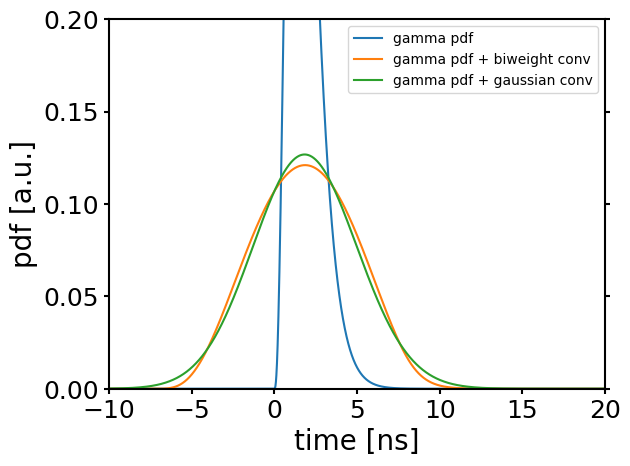

In [11]:
fig, ax = plt.subplots()

ax.plot(xvals, yvals_gamma, label='gamma pdf')
ax.plot(xvals, yvals_biweight_conv_gamma, label='gamma pdf + biweight conv')
ax.plot(xvals, yvals_gaussian_conv_gamma, label='gamma pdf + gaussian conv')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 20], 
                 'ylim':[0.0, 0.2]}

adjust_plot_1d(fig, ax, plot_args=plot_args)

(1e-06, 1)

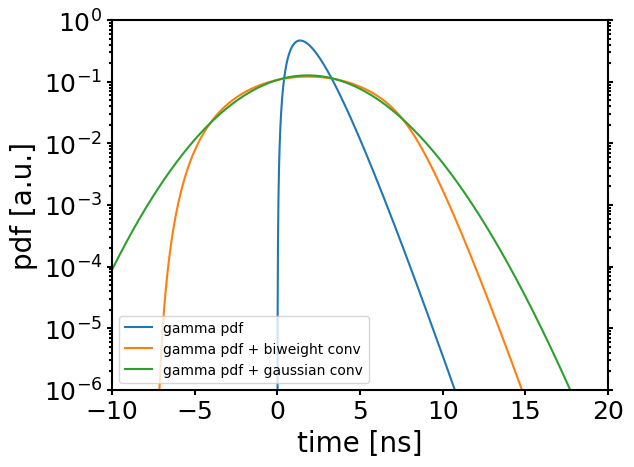

In [12]:
fig, ax = plt.subplots()

ax.plot(xvals, yvals_gamma, label='gamma pdf')
ax.plot(xvals, yvals_biweight_conv_gamma, label='gamma pdf + biweight conv')
ax.plot(xvals, yvals_gaussian_conv_gamma, label='gamma pdf + gaussian conv')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 20], 
                 'ylim':[0.0, 0.2]}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.yscale('log')
plt.ylim([1.e-6, 1])